In [1]:
import pickle

import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

import mlflow
import os
from dotenv import load_dotenv

from plotnine import *
load_dotenv()

True

In [2]:
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI")
MLFLOW_TRACKING_TOKEN = os.getenv("MLFLOW_TRACKING_TOKEN") #set from `gcloud auth print-identity-token`
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [16]:
MLFLOW_TRACKING_URI

'https://mlflow-cloud-run-vjzmjpwslq-uc.a.run.app'

In [4]:
mlflow.set_experiment("predict-green-taxi-ride-duration")

<Experiment: artifact_location='oneclick-mlflow-store-70af159ded/1', experiment_id='1', lifecycle_stage='active', name='predict-green-taxi-ride-duration', tags={}>

In [47]:
def prepare_data(url_path: str):
    df = pd.read_parquet(url_path, engine="pyarrow")
    
    # Convert column names to uppercase to handle naming inconsistencies
    df.columns = df.columns.str.upper()
    
    # Calculate ride duration
    df["DURATION"] = (df["LPEP_DROPOFF_DATETIME"] - df["LPEP_PICKUP_DATETIME"]) / pd.Timedelta("1 min")
    
    df = (df
          .assign(
             PULOCATIONID = df["PULOCATIONID"].fillna(-1).astype('category'),
             DOLOCATIONID = df["DOLOCATIONID"].fillna(-1).astype('category'),
             #ROUTE = lambda df_: df_.groupby(["PULOCATIONID","DOLOCATIONID"], sort=False).ngroup().astype("category")
             ROUTE = f'{df["PULOCATIONID"].astype(str)}_{df["DOLOCATIONID"].astype(str)}'
           )
          .loc[(df.DURATION >= 1) & (df.DURATION <= 60), :]
        )
    
    dicts = df.loc[:, ["ROUTE", "TRIP_DISTANCE"]].to_dict(orient="records")
    y = df["DURATION"].values
    return dicts, y

    
    
    

In [48]:
train_dict, y_train = prepare_data("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-01.parquet")
val_dict, y_val = prepare_data("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-02.parquet")

In [49]:
with mlflow.start_run():
    params = dict(max_depth=20, n_estimators=100, min_samples_leaf=10, random_state=0)
    mlflow.log_params(params)

    pipeline = make_pipeline(
        DictVectorizer(),
        RandomForestRegressor(**params, n_jobs=-1)
    )

    pipeline.fit(train_dict, y_train)
    y_pred = pipeline.predict(val_dict)

    rmse = mean_squared_error(y_pred, y_val, squared=False)
    print(params, rmse)
    mlflow.log_metric('rmse', rmse)

    mlflow.sklearn.log_model(pipeline, artifact_path="model", serialization_format="cloudpickle", registered_model_name="SklearnRFGreenTaxi")

{'max_depth': 20, 'n_estimators': 100, 'min_samples_leaf': 10, 'random_state': 0} 6.874591537904081


Registered model 'SklearnRFGreenTaxi' already exists. Creating a new version of this model...
2022/06/20 00:40:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: SklearnRFGreenTaxi, version 2
Created version '2' of model 'SklearnRFGreenTaxi'.


In [50]:
import mlflow.pyfunc
model_name = "SklearnRFGreenTaxi"
model_version = 2
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

model.predict({'ROUTE': 16, 'TRIP_DISTANCE': 36.66})

array([46.56738292])

In [20]:
val_dict

[{'ROUTE': 0, 'TRIP_DISTANCE': 3.66},
 {'ROUTE': 1, 'TRIP_DISTANCE': 1.1},
 {'ROUTE': 2, 'TRIP_DISTANCE': 4.93},
 {'ROUTE': 3, 'TRIP_DISTANCE': 6.7},
 {'ROUTE': 4, 'TRIP_DISTANCE': 1.89},
 {'ROUTE': 5, 'TRIP_DISTANCE': 3.3},
 {'ROUTE': 6, 'TRIP_DISTANCE': 2.51},
 {'ROUTE': 7, 'TRIP_DISTANCE': 1.68},
 {'ROUTE': 8, 'TRIP_DISTANCE': 1.44},
 {'ROUTE': 9, 'TRIP_DISTANCE': 0.0},
 {'ROUTE': 10, 'TRIP_DISTANCE': 1.9},
 {'ROUTE': 11, 'TRIP_DISTANCE': 1.9},
 {'ROUTE': 12, 'TRIP_DISTANCE': 1.73},
 {'ROUTE': 13, 'TRIP_DISTANCE': 0.94},
 {'ROUTE': 14, 'TRIP_DISTANCE': 3.24},
 {'ROUTE': 15, 'TRIP_DISTANCE': 1.67},
 {'ROUTE': 16, 'TRIP_DISTANCE': 1.2},
 {'ROUTE': 19, 'TRIP_DISTANCE': 0.93},
 {'ROUTE': 20, 'TRIP_DISTANCE': 0.83},
 {'ROUTE': 21, 'TRIP_DISTANCE': 1.3},
 {'ROUTE': 22, 'TRIP_DISTANCE': 8.31},
 {'ROUTE': 23, 'TRIP_DISTANCE': 5.8},
 {'ROUTE': 24, 'TRIP_DISTANCE': 2.22},
 {'ROUTE': 25, 'TRIP_DISTANCE': 1.77},
 {'ROUTE': 26, 'TRIP_DISTANCE': 7.49},
 {'ROUTE': 27, 'TRIP_DISTANCE': 3.79},
 {'RO

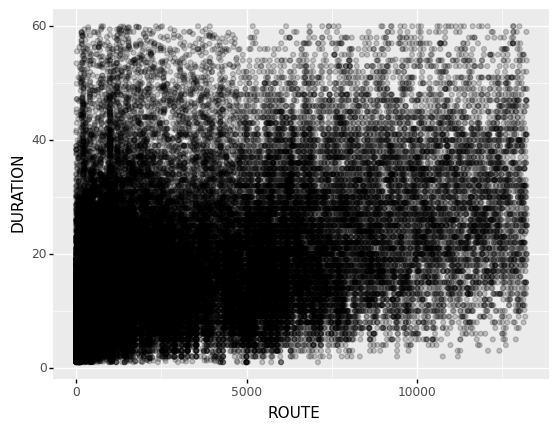

<ggplot: (318795168)>

In [ ]:
ggplot(df, aes(x="ROUTE", y="DURATION")) + geom_jitter(alpha=0.2)

In [28]:
url_path="https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-01.parquet"
df = pd.read_parquet(url_path, engine="pyarrow")
    
    # Convert column names to uppercase to handle naming inconsistencies
df.columns = df.columns.str.upper()

In [37]:
df["ROUTE"] = df[["PULOCATIONID","DOLOCATIONID"]].agg(tuple, axis=1)

In [43]:
df["ROUTE"]

0         (43, 151)
1        (166, 239)
2          (41, 42)
3         (168, 75)
4        (265, 265)
            ...    
76513      (81, 90)
76514     (35, 213)
76515      (74, 69)
76516    (168, 215)
76517    (119, 244)
Name: ROUTE, Length: 76518, dtype: object